## Shift the location of iceberg calving a bit further off the coast for isolated bays

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.forcing import create_calving, calving_at_coastline
from nemo_python_git.grid import get_coast_mask, get_icefront_mask

#### Load files

In [2]:
# NEMO mesh mask and domain files
base_dir     = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mask    = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250217.nc')

# Original calving dataset (same underlying grid, but different coastline)
calving     = xr.open_dataset(f'{base_dir}misc-forcing/eORCA025_calving_b0.2_v2.3_nohls.nc').isel(time_counter=0, y=slice(0,453)) # subset global file

In [3]:
cesm2_1920 = f'{base_dir}output/CESM2_t0_ens1011_monthly_highresbias_1920/files0/'
cesm2icb = xr.open_dataset(f'{cesm2_1920}../restart/eANT025.L121_00888320_restart_icb.nc')
cesm2ni0 = xr.open_dataset(f'{cesm2_1920}eANT025.L121_1m_19560101_19561231_icemod.nc')

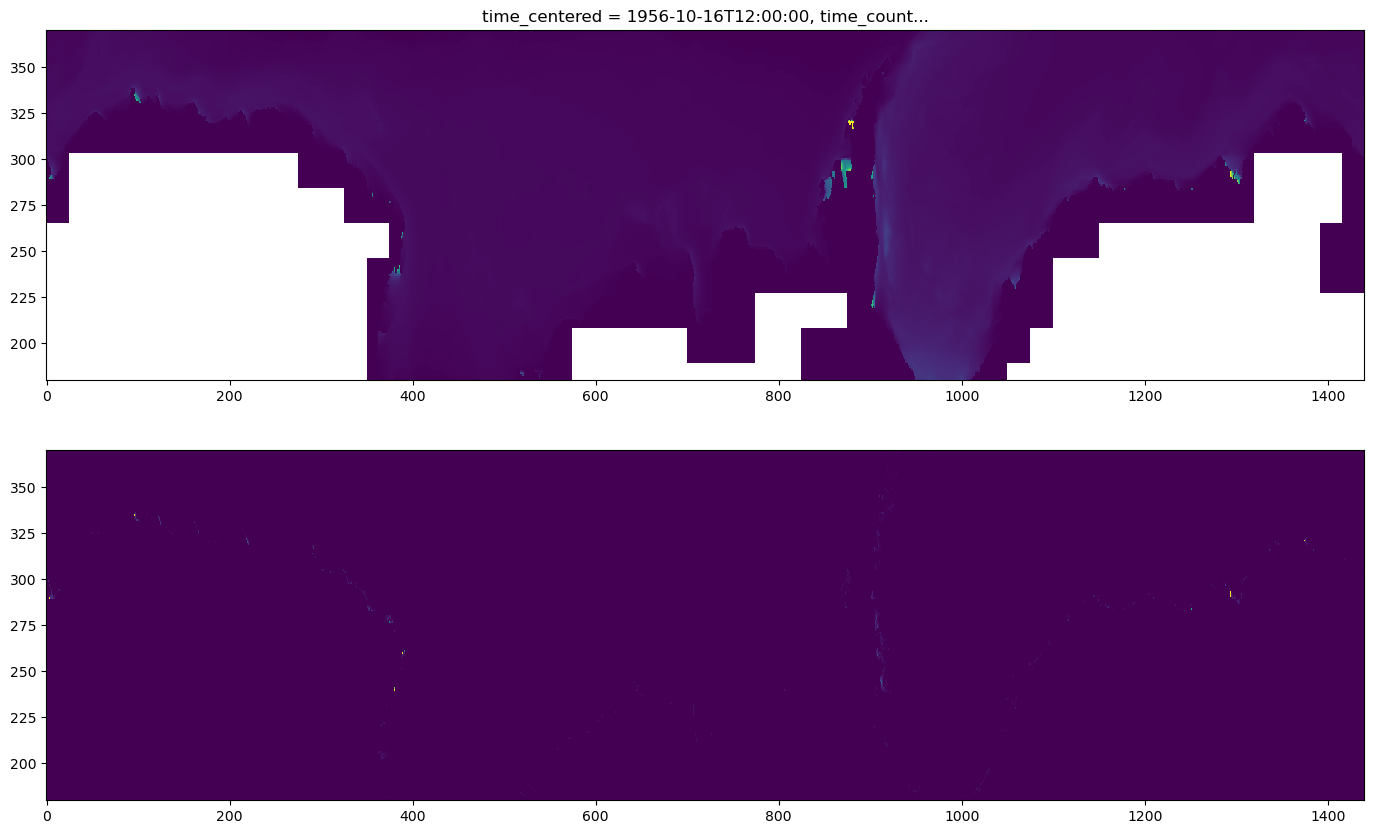

In [25]:
fig, ax = plt.subplots(2,1, figsize=(17,10))
cesm2ni0.sithic.isel(time_counter=9).plot(ylim=(180,370), vmin=0, vmax=60, ax=ax[0], add_colorbar=False)
cesm2icb.virtual_area.plot(vmin=0, vmax=1e9, ax=ax[1], ylim=(180,370), add_colorbar=False)
for axis in ax.ravel():
    axis.set_xlabel('')
    axis.set_ylabel('')

### Move calving to the new coastline

The function "create_calving" in forcing.py:
- Identifies locations with calving that need to be moved by calling calving_at_coastline()
- Gets ocean iceshelf edge points by calling get_icefront_mask()
- Shift calving points to the nearest ocean iceshelf edge points by calling shift_calving()
- Writes the new calving variable to a NetCDF file

In [4]:
# move pre-existing calving dataset to the new coastline/bathymetry in NEMO_mesh
new_calving = create_calving(calving, nemo_mask, calving_var='soicbclv', 
                             new_file_path=f'{base_dir}misc-forcing/AntArc_eORCA025_calving_b0.2_v2.3_nohls_test.nc')

#### Visualisation of shifted points

First, create masks of the coastline and iceshelf front

In [5]:
# Mask of ocean grid points of icefront (icefront_mask_ice), 
#         ocean point nearest to icefront (icefront_mask_ocn), 
#         first land points (coastline)
icefront_mask_ice = get_icefront_mask(nemo_mask, side='ice')
icefront_mask_ocn = get_icefront_mask(nemo_mask, side='ocean')
coast_mask        = get_coast_mask(nemo_mask)

The figures below show the grid points identified by the above function as coastline and icshelf front (ocean side, and ice side)

In [6]:
def coastline_vis(coast_mask, icefront_mask_ice, icefront_mask_ocn, nemo_mask):

    x, y     = np.meshgrid(nemo_mask.x, nemo_mask.y)
    # x, y grid points of the coastline, iceshelf front, etc.
    coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x); coast_y  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y);
    isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y);
    isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y);
    
    fig, ax = plt.subplots(1,2, figsize=(20,6))
    
    ax[0].set_title('Antarctica')
    ax[0].set_xlim(0, 1453)
    ax[0].set_ylim(150, 400)
    # Plot points associated with the coastline, icefront, etc.
    ax[0].scatter(coast_x , coast_y , c='brown', s=1, label='Coastline');
    ax[0].scatter(isfice_x, isfice_y, c='c', s=1, label='Icefront - ice');
    ax[0].scatter(isfocn_x, isfocn_y, c='b', s=1, label='Icefront - ocean');
    ax[0].legend(frameon=False, fontsize=12, loc=(0.7, 0.05), markerscale=5)
    
    ax[1].set_title('Zoom in on Pine Island Bay')
    ax[1].set_xlim(700, 780)
    ax[1].set_ylim(200, 270)
    # Plot points associated with the coastline, icefront, etc.
    ax[1].scatter(coast_x , coast_y , c='brown', s=7, label='Coastline');
    ax[1].scatter(isfice_x, isfice_y, c='c', s=7, label='Icefront - ice');
    ax[1].scatter(isfocn_x, isfocn_y, c='b', s=7, label='Icefront - ocean');
    ax[1].legend(frameon=False, fontsize=12, loc=(0.7, 0.05), markerscale=2)
    
    for axis in ax.ravel():
        axis.set_xlabel('x grid point')
        axis.set_ylabel('y grid point')
    
    return

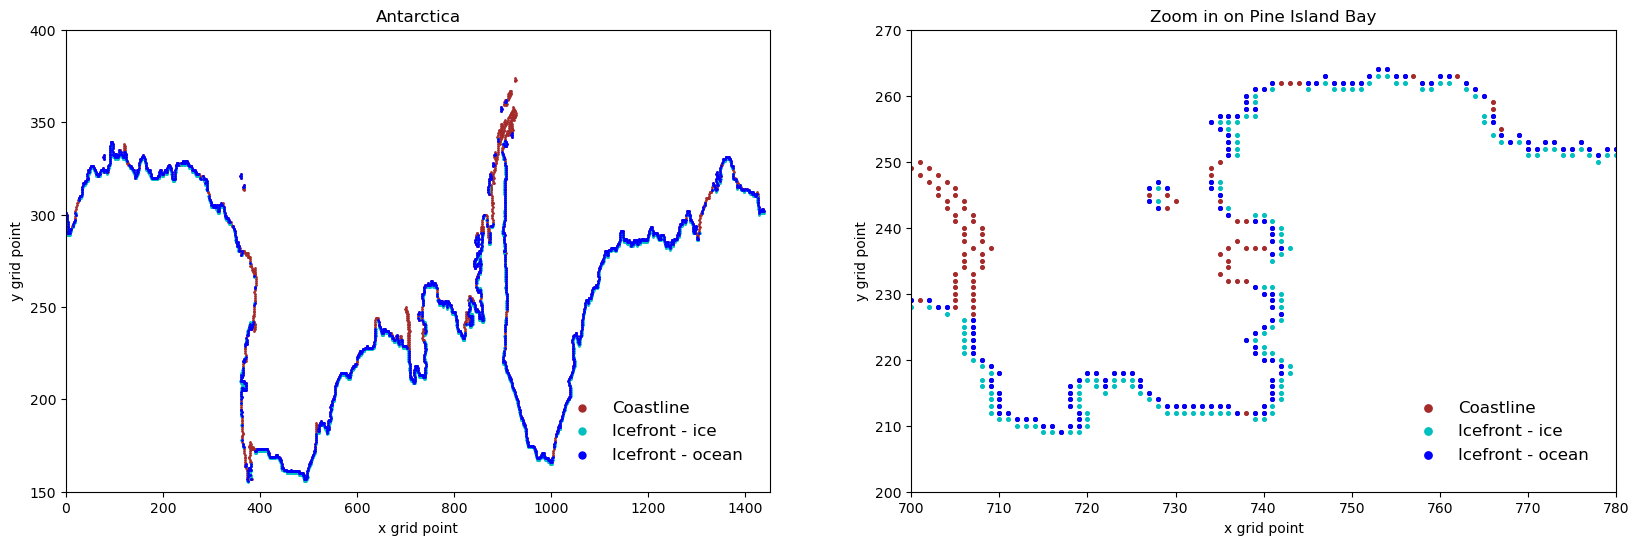

In [20]:
coastline_vis(coast_mask, icefront_mask_ice, icefront_mask_ocn, nemo_mask)

Then, focussing in on Pine Island Bay as an example region, we can compare the calving locations from the original dataset (bottom left) and the calving locations produced by create_calving (bottom right). Note that there are a number of black circles in the bottom left that do not have a dark blue dot in the middle, so the calving does not occur at an ocean point closest to the icefront. There are also some instances where calving occured on the iceshelf instead or on land.

In [7]:
calving_ocn, calving_land, calving_ice = calving_at_coastline(calving['soicbclv'], nemo_mask)

In [8]:
def calving_vis(old_var, new_var, coast_mask, icefront_mask_ice, icefront_mask_ocn, nemo_mask, \
                xlim=(600,800), ylim=(200,270), title='PI bay', bigger_fig=False):

    x, y     = np.meshgrid(nemo_mask.x, nemo_mask.y)
    # x, y grid points of the coastline, iceshelf front, etc.
    coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x); coast_y  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y);
    isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y);
    isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y);
    # x, y grid points of calving
    calving_x_old = np.ma.masked_where(old_var.values==0, x); calving_y_old = np.ma.masked_where(old_var.values==0, y);
    calving_x_new = np.ma.masked_where(new_var.values==0, x); calving_y_new = np.ma.masked_where(new_var.values==0, y);
    
    if bigger_fig:
        fig, ax = plt.subplots(1,3, figsize=(20,6))
    else:
        fig, ax = plt.subplots(1,2, figsize=(20,6))
        
    ax[0].scatter(calving_x_old, calving_y_old, c='w'     , s=60, edgecolor='k', label='Old calving locations');
    ax[1].scatter(calving_x_new, calving_y_new, c='w'     , s=60, edgecolor='k', label='New calving locations');
    
    for axis in ax.ravel()[0:2]:
        axis.set_title(title)
        axis.set_xlim(xlim[0], xlim[1])
        axis.set_ylim(ylim[0], ylim[1])
        axis.set_xlabel('x grid point')
        axis.set_ylabel('y grid point')
        # Plot points associated with the coastline, icefront, etc.
        axis.scatter(coast_x , coast_y , c='brown', s=7, label='Coastline');
        axis.scatter(isfice_x, isfice_y, c='c', s=7, label='Icefront - ice');
        axis.scatter(isfocn_x, isfocn_y, c='b', s=7, label='Icefront - ocean');
        axis.legend(frameon=False, fontsize=12, markerscale=2)
        
    return fig, ax

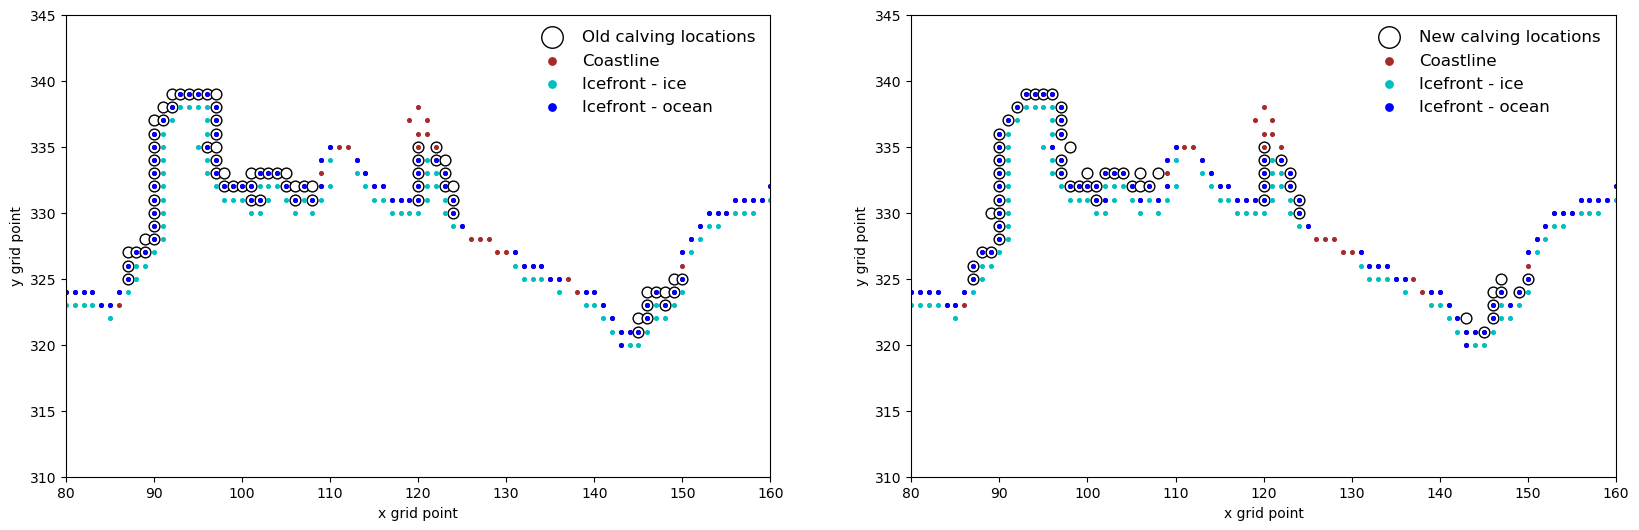

In [9]:
# show locations where calving occurs and where it needs to be moved
_,_ = calving_vis(calving.soicbclv, new_calving.soicbclv.isel(time_counter=0),
            coast_mask, icefront_mask_ice, icefront_mask_ocn, nemo_mask, xlim=(80,160), ylim=(310,345), title='')

places to fix:
- x=slice(0,15), y=slice(280,305)
- x=slice(90,100), y=slice(330,340)
- x=slice(120,130), y=slice(325,340)
- x=slice(160,180), y=slice(320,335)
- x=slice(210,225), y=slice(315,325)
- x=slice(280,300), y=slice(310,325)
- x=slice(350,360), y=slice(275,295)
- x=slice(370,395), y=slice(225,290)
- x=slice(510,540), y=slice(170,200)
- x=slice(865,895), y=slice(280,310)
- x=slice(890,910), y=slice(270,300)
- x=slice(1240,1310), y=slice(280,310)
- x=slice(1370,1390), y=slice(310,330)

In [9]:
# x_issues = [(0,15)   , (90,100),(115,128),(160,170),(210,225),(280,300),(350,360),(370,395),(510,540),(865,895),(890,910),(1240,1310),(1370,1390)]
# y_issues = [(285,305),(330,340),(325,340),(320,335),(315,325),(310,325),(275,295),(230,290),(170,200),(280,310),(270,300),(280,310)  ,(310,330)  ]
# Removed the ones that don't really seem to be iceberg issues:
x_issues = [(0,15)   , (90,100),(115,128),(210,225),(350,360),(370,395),(895,910),(1245,1300),(1370,1390)]
y_issues = [(285,305),(330,340),(325,340),(315,325),(275,295),(230,290),(270,300),(280,300)  ,(310,330)  ]

/opt/jaspy/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


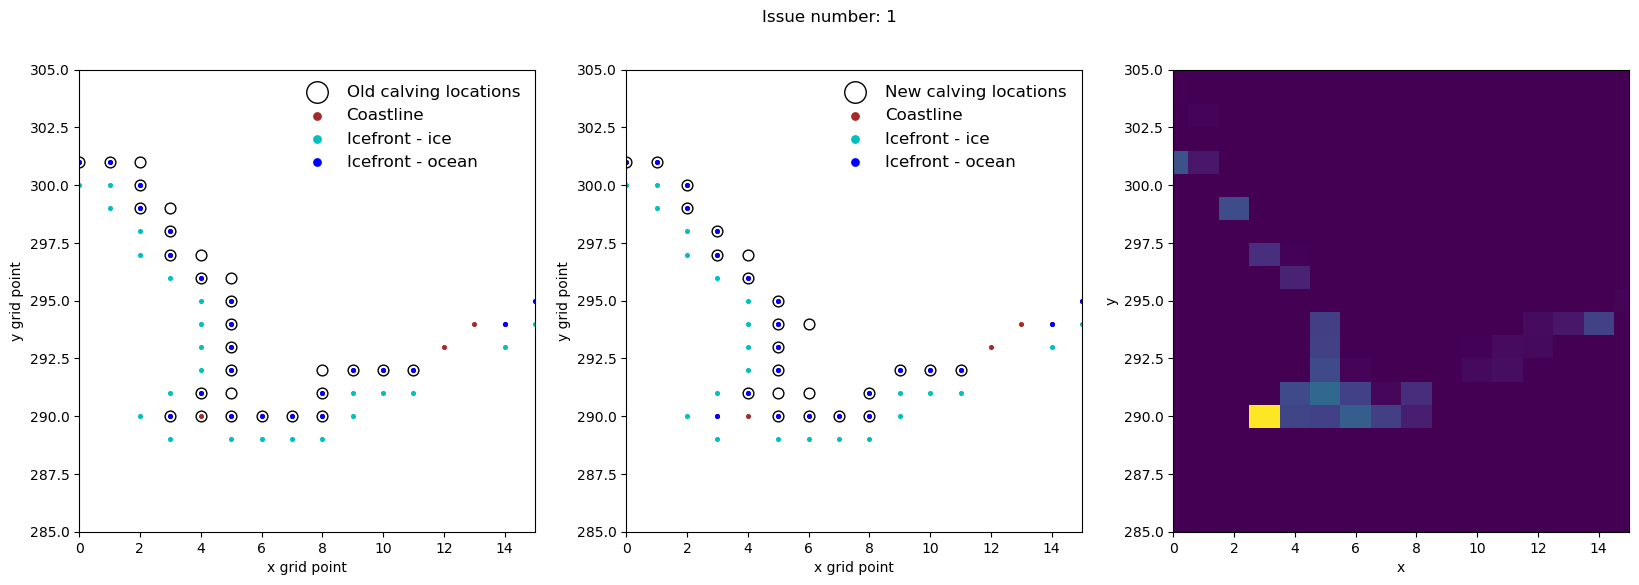

/opt/jaspy/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


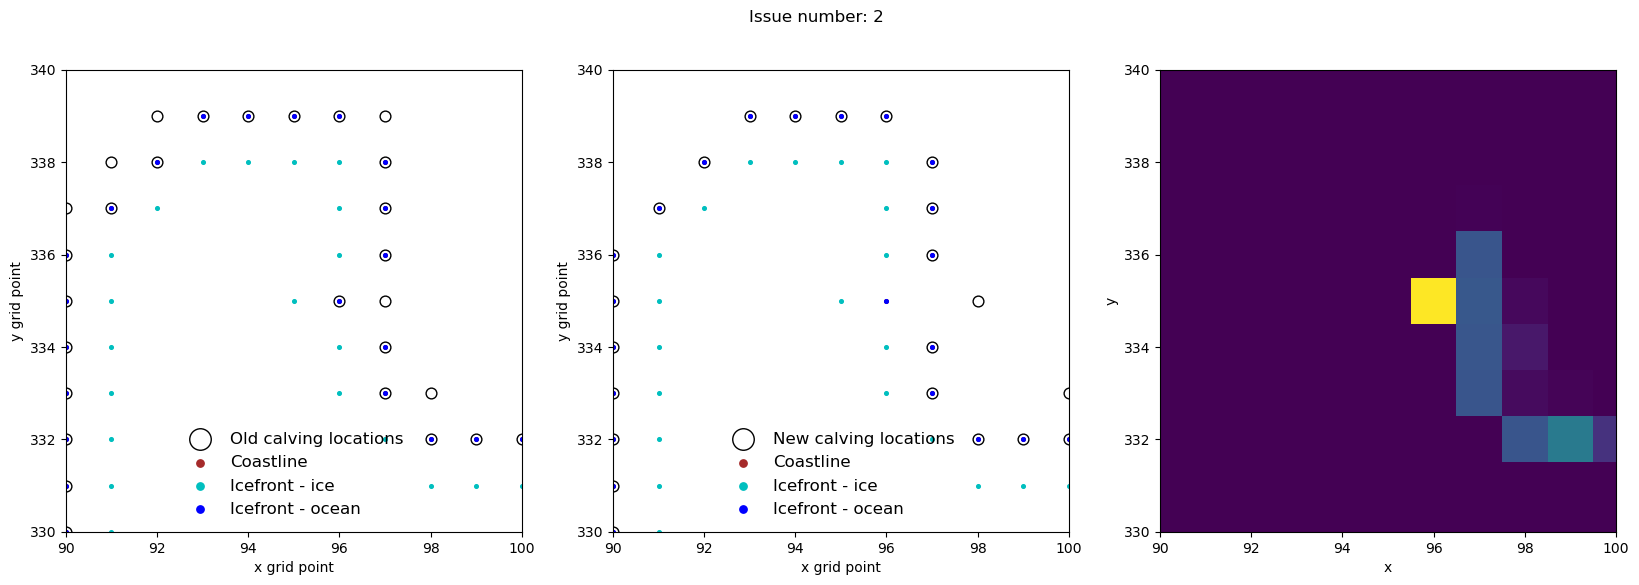

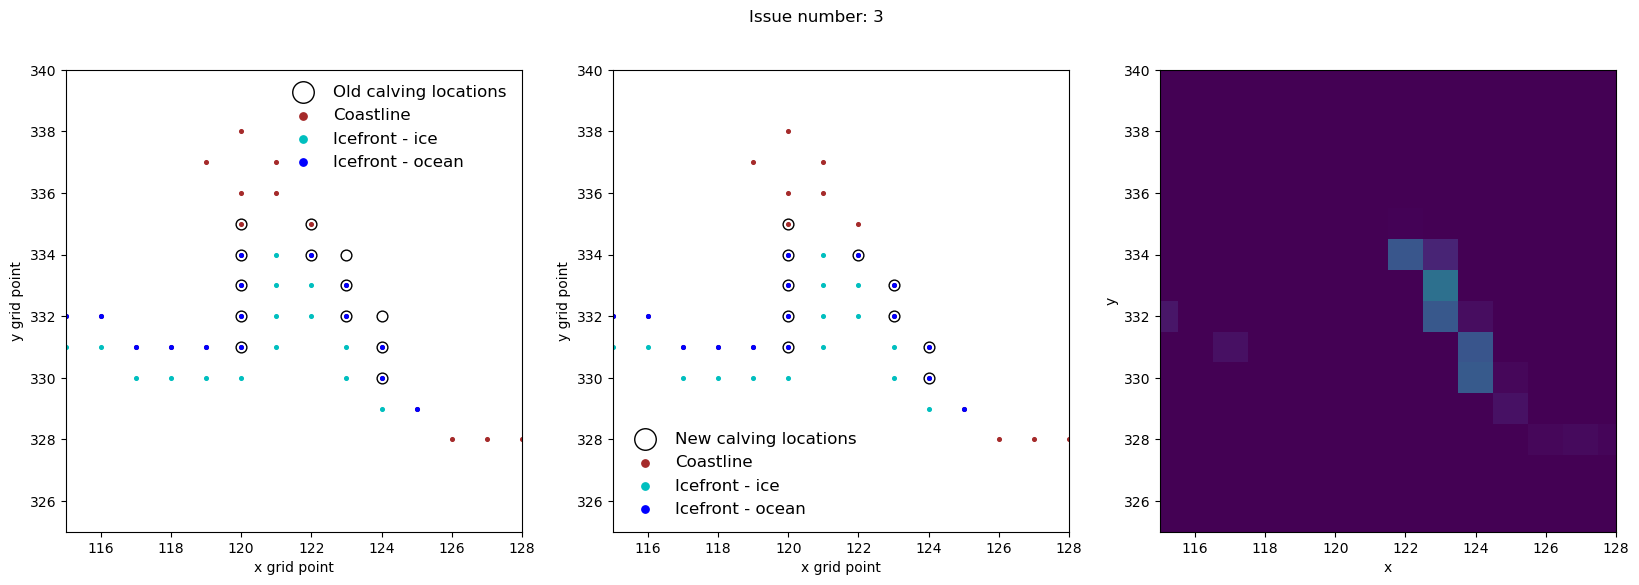

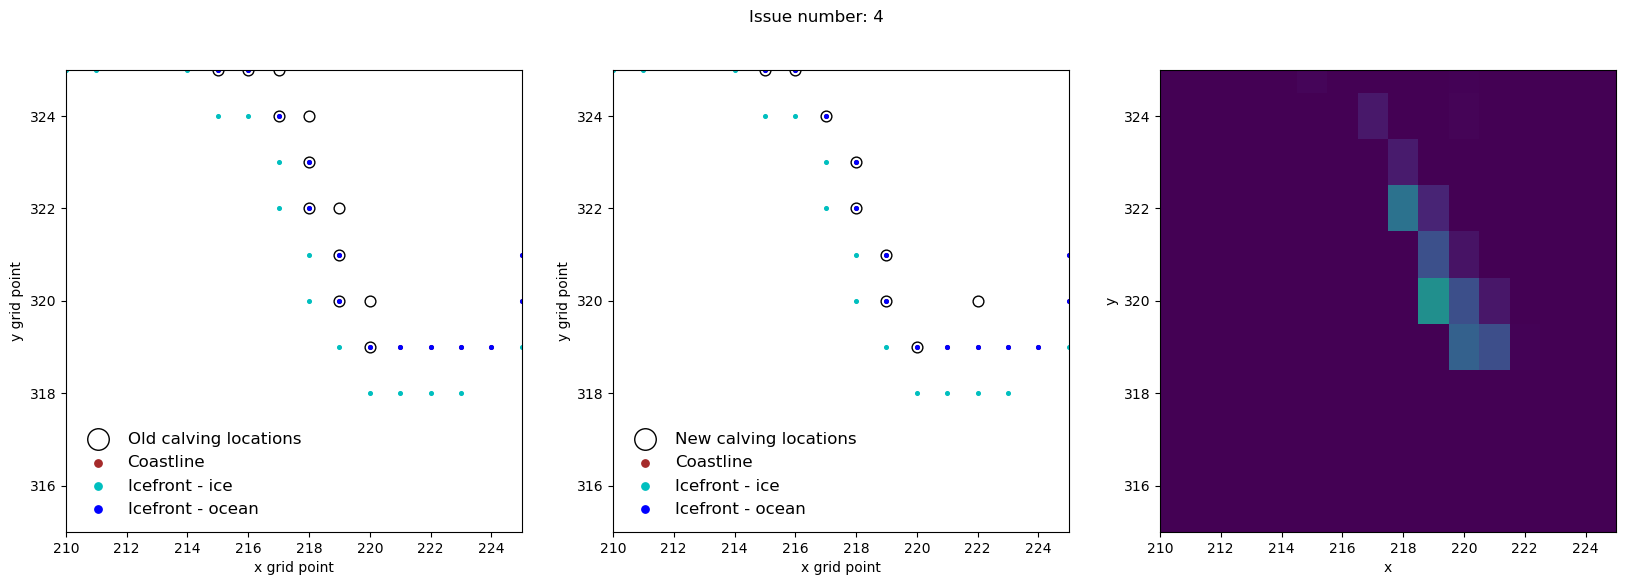

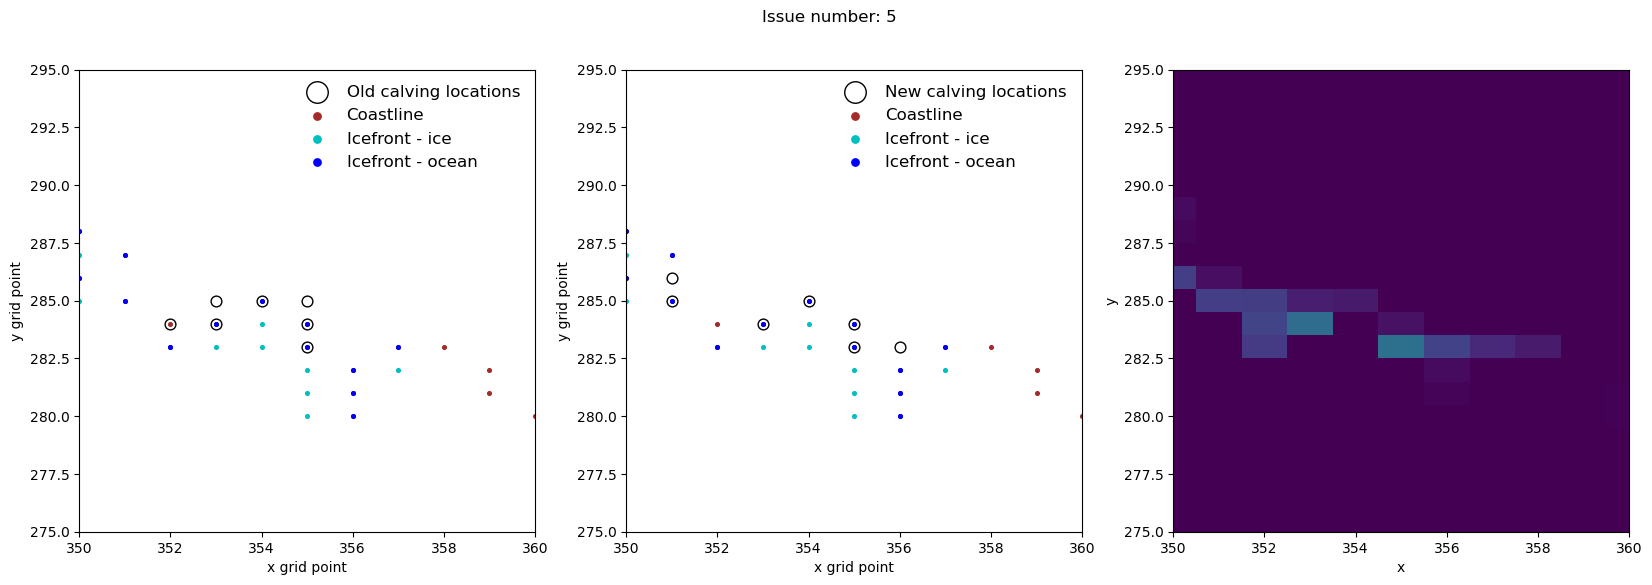

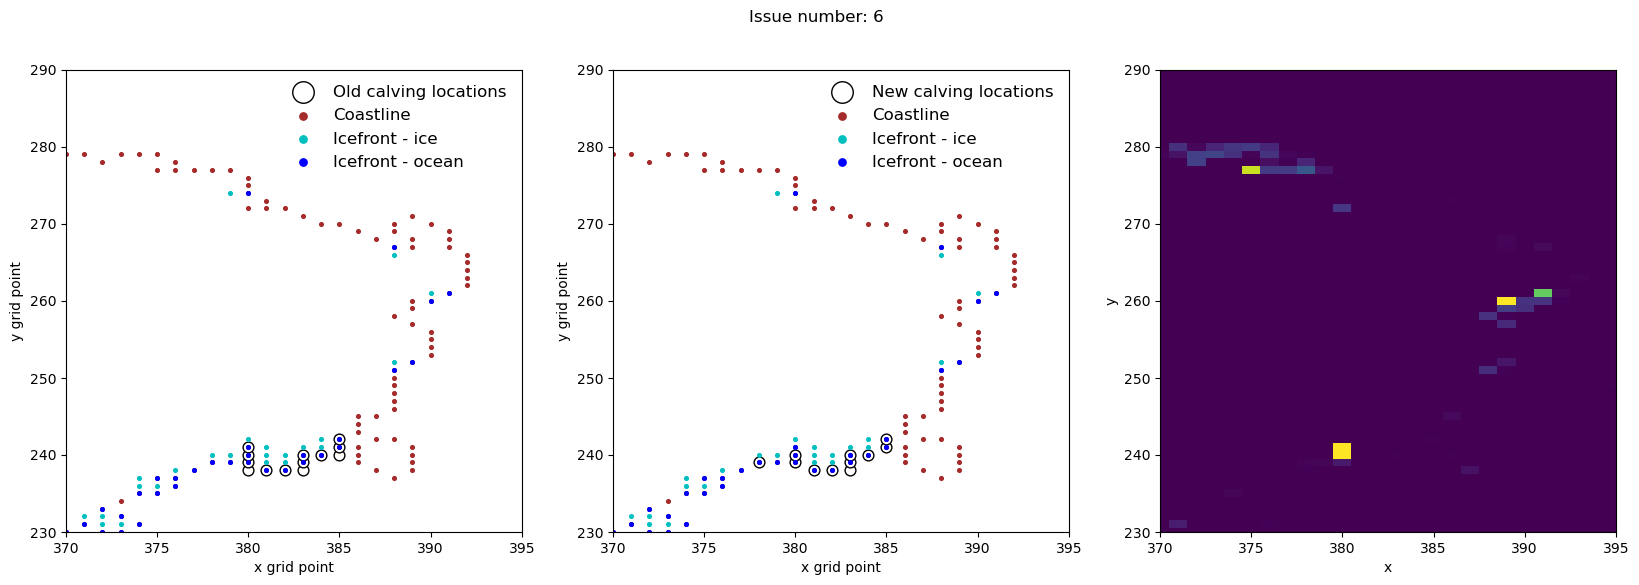

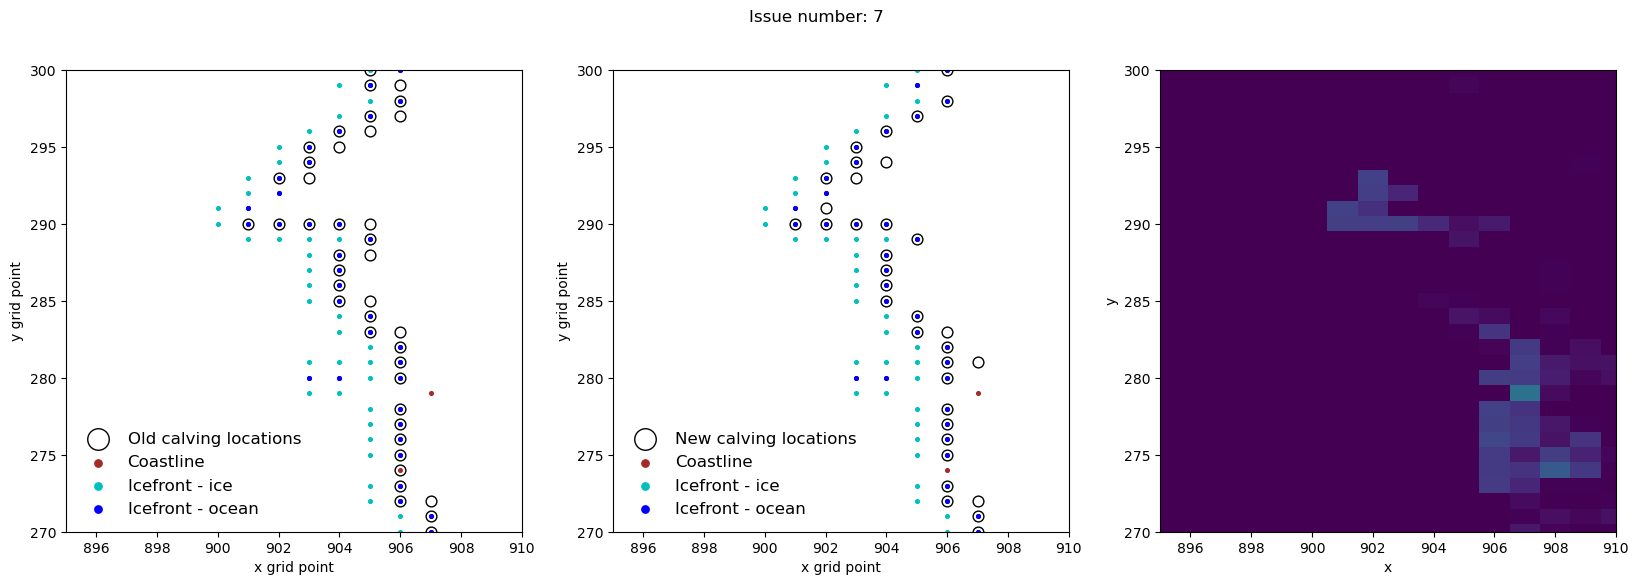

In [ ]:
for i in range(len(x_issues)):
    fig, ax = calving_vis(calving.soicbclv, new_calving.soicbclv.isel(time_counter=0), coast_mask, icefront_mask_ice, icefront_mask_ocn, nemo_mask,
                          xlim=(x_issues[i][0],x_issues[i][1]), ylim=(y_issues[i][0],y_issues[i][1]), title='', bigger_fig=True)
    
    # cesm2ni0.sithic.isel(time_counter=9).plot(xlim=(x_issues[i][0],x_issues[i][1]), ylim=(y_issues[i][0],y_issues[i][1]), 
    #                                           vmin=0, vmax=20, ax=ax[2], add_colorbar=False)
    cesm2icb.virtual_area.plot(xlim=(x_issues[i][0],x_issues[i][1]), ylim=(y_issues[i][0],y_issues[i][1]), 
                                vmin=0, vmax=5e8, ax=ax[2], add_colorbar=False)
    
    fig.suptitle(f'Issue number: {i+1}')

In [ ]:
calving.soicbclv, new_calving.soicbclv.isel(time_counter=0)

In [32]:
new_calving.soicbclv

<xarray.DataArray 'soicbclv' (time_counter: 1, y: 453, x: 1440)> Size: 3MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Dimensions without coordinates: time_counter, y, x

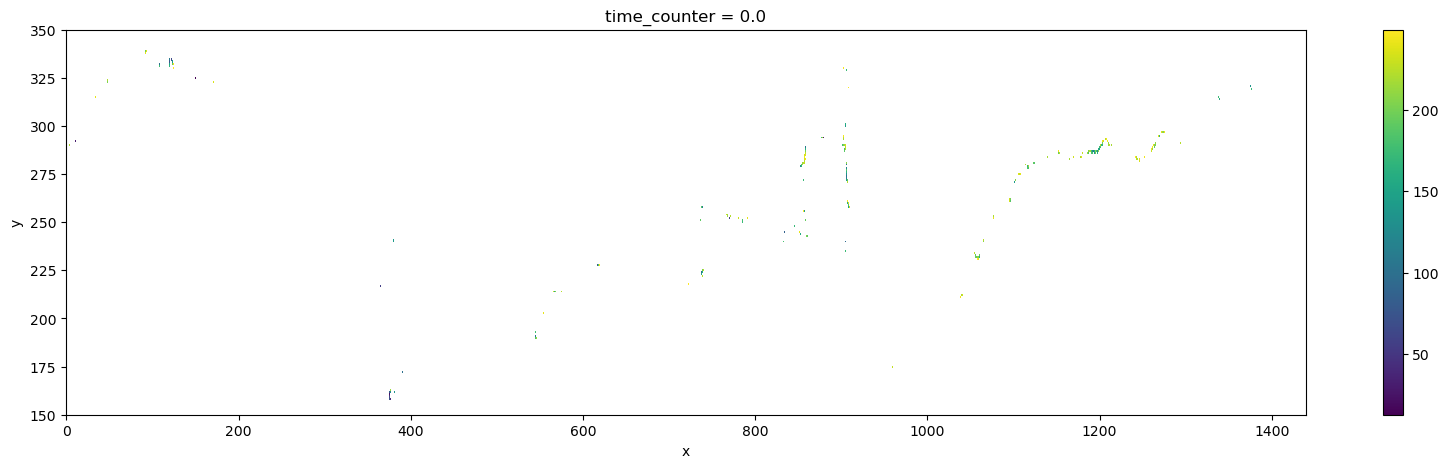

In [64]:
calving_depth = nemo_mask.bathy_metry.squeeze()*(calving.soicbclv.squeeze().astype(bool))
calving_depth.where((calving_depth<250)*(calving_depth>0)).plot(figsize=(20,5), ylim=(150,350))

In [61]:
np.sum(~np.isnan(calving_depth.where((calving_depth<40)*(calving_depth>0))))

<xarray.DataArray ()> Size: 8B
array(4)
Coordinates:
    time_counter  float32 4B 0.0